# Pneumonia classification project

Link in kaggel: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.
For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

### Import libraries + set-up

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow.keras import mixed_precision

import datetime

Configuration of memory usage. This could prevent unnecessary GPU memory usage. Memory will only be allocated on demand.

In [2]:
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

Exploring the X-ray data directory.

In [3]:
dir_path = "D:\\Datasets\\chest_xray"
for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(filenames)} images and {len(dirnames)} directories in {dirpath}")

There are 0 images and 2 directories in D:\Datasets\chest_xray
There are 0 images and 2 directories in D:\Datasets\chest_xray\test
There are 234 images and 0 directories in D:\Datasets\chest_xray\test\NORMAL
There are 390 images and 0 directories in D:\Datasets\chest_xray\test\PNEUMONIA
There are 0 images and 2 directories in D:\Datasets\chest_xray\train
There are 1349 images and 0 directories in D:\Datasets\chest_xray\train\NORMAL
There are 3883 images and 0 directories in D:\Datasets\chest_xray\train\PNEUMONIA


Creating list of filepaths for each class.

In [4]:
normal_path = "D:\\Datasets\\chest_xray\\train\\NORMAL"
pneumonia_path = "D:\\Datasets\\chest_xray\\train\\PNEUMONIA"
normal_image_paths = []
for root, _, files in os.walk(normal_path):
    for filename in files:
        normal_image_paths.append(os.path.join(root, filename))
        
pneumonia_image_paths = []
for root, _, files in os.walk(pneumonia_path):
    for filename in files:
        pneumonia_image_paths.append(os.path.join(root, filename))

len(normal_image_paths), len(pneumonia_image_paths)

(1349, 3883)

### Data visualization and analysis
Visualization of the number of instances for each class. As we can see, the data is skewed. To compensate for that, we can use undersampling for the majority class (simply randomly remove some instances) and oversampling for the minority class (this can be done by a generative neural network). Additionally, we can assign class weights for each class, so minority samples will have more influence on the loss function convergence.

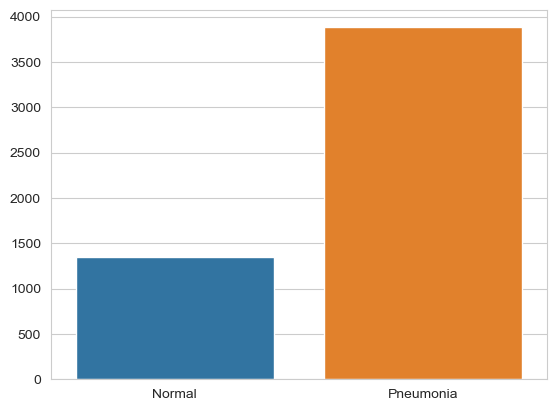

In [5]:
df = pd.DataFrame(data=[[len(normal_image_paths), len(pneumonia_image_paths)]],
                  columns=["Normal","Pneumonia"])

sns.set_style(style="whitegrid")
sns.barplot(df);

Visualizing the dataset (one row per class). As we can see, fluorography instances of the "pneumonia" class are often distorted by medical equipment and marker notes. This can lead to situation whan our model will tend to predict class "pneumonia" if it will see that equipment. This can also significant reduce accuracy of predictions.

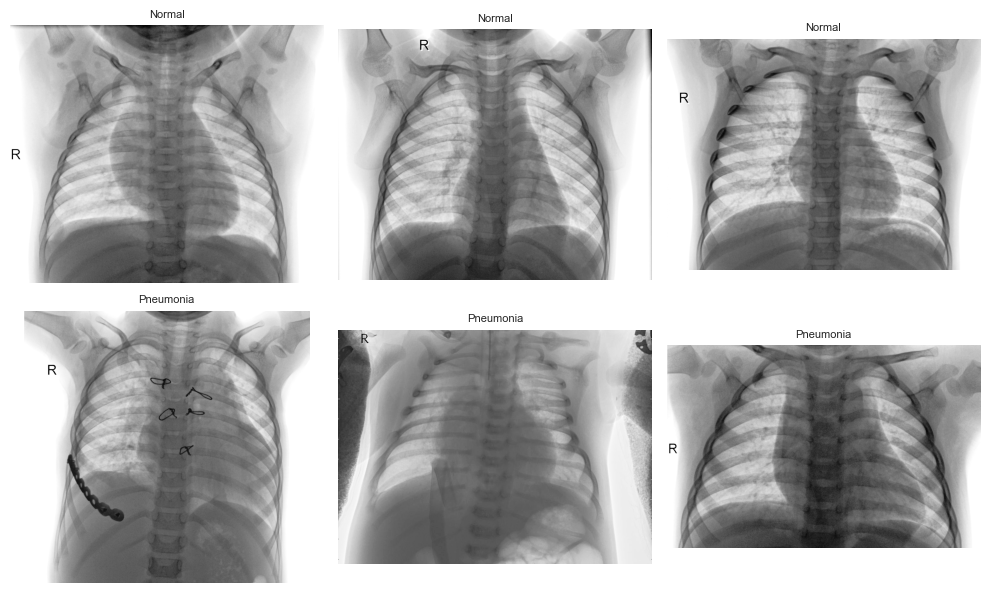

In [6]:
count = 3
rand_normal = np.random.randint(0, len(normal_image_paths), count)
rand_pneumonia = np.random.randint(0, len(pneumonia_image_paths), count)
fig, axes = plt.subplots(nrows=2, ncols=count, figsize=(10, 6))
for image in range(count):
    ax = axes[0, image] 
    ax.imshow(mpimg.imread(normal_image_paths[rand_normal[image]]), cmap=plt.cm.Greys)
    ax.set_title("Normal", fontsize=8)
    ax.axis('off')
for image in range(count):
    ax = axes[1, image] 
    ax.imshow(mpimg.imread(pneumonia_image_paths[rand_pneumonia[image]]), cmap=plt.cm.Greys)
    ax.set_title("Pneumonia", fontsize=8)
    ax.axis('off')
plt.tight_layout()

Creating class weights for compensating unbalance in data.

In [7]:
normal_count = len(normal_image_paths)
pneumonia_count = len(pneumonia_image_paths)

weight_for_normal_class = (1 / normal_count)*(normal_count+pneumonia_count)/2.0 
weight_for_pneumonia_class = (1 / pneumonia_count)*(normal_count+pneumonia_count)/2.0

class_weight = {0: weight_for_normal_class, 1: weight_for_pneumonia_class}
class_weight

{0: 1.939214232765011, 1: 0.6737058975019315}

Creating a list of file paths. As we can see, there are roughly 4600 images for the training dataset and 630 instances for each the validation and test data.

In [8]:
train_val_filenames = tf.io.gfile.glob(str("D:\\Datasets\\chest_xray\\train\\*\\*"))
train_filenames, val_filenames = train_test_split(train_val_filenames, test_size=0.12, random_state=42) 
test_filenames = tf.io.gfile.glob(str("D:\\Datasets\\chest_xray\\test\\*\\*"))
len(train_filenames), len(val_filenames), len(test_filenames)

(4604, 628, 624)

In [9]:
from collections import Counter
train_sample = []
val_sample = []
test_sample = []

for filename in train_filenames:
    train_sample.append(os.path.basename(os.path.dirname(filename)))
for filename in val_filenames:
    val_sample.append(os.path.basename(os.path.dirname(filename)))
for filename in test_filenames:
    test_sample.append(os.path.basename(os.path.dirname(filename)))
    
train_unique, val_unique, test_unique = Counter(train_sample), Counter(val_sample), Counter(test_sample)

train_unique = {'PNEUMONIA': train_unique['PNEUMONIA'], 'NORMAL': train_unique['NORMAL']}
val_unique = {'PNEUMONIA': val_unique['PNEUMONIA'], 'NORMAL': val_unique['NORMAL']}
test_unique = {'PNEUMONIA': test_unique['PNEUMONIA'], 'NORMAL': test_unique['NORMAL']}

print(f"Thare are {train_unique['PNEUMONIA']} pneumonia and {train_unique['NORMAL']} normal instances in the train dataset")
print(f"Thare are {val_unique['PNEUMONIA']} pneumonia and {val_unique['NORMAL']} normal instances in the validation dataset")
print(f"Thare are {test_unique['PNEUMONIA']} pneumonia and {test_unique['NORMAL']} normal instances in the test dataset\n")
print("Ratios of Pneumonia/Normal:")
print(f"Train dataset: {round(train_unique['PNEUMONIA']/train_unique['NORMAL'],3)}")
print(f"Validation dataset: {round(val_unique['PNEUMONIA']/val_unique['NORMAL'],3)}")
print(f"Test dataset: {round(test_unique['PNEUMONIA']/test_unique['NORMAL'],3)}")

Thare are 3428 pneumonia and 1176 normal instances in the train dataset
Thare are 455 pneumonia and 173 normal instances in the validation dataset
Thare are 390 pneumonia and 234 normal instances in the test dataset

Ratios of Pneumonia/Normal:
Train dataset: 2.915
Validation dataset: 2.63
Test dataset: 1.667


Test data is significantly less skewed. This can reduce accuracy of real world model performance.

### Image preproccesing and data preparation

In [10]:
IMAGE_SHAPE = 227

@tf.function
def load_and_preprocess_image(filenames, image_shape=IMAGE_SHAPE, rescale=True):
    """
    This function reads file paths, extracts, resizes, and scales image tensors. It also returns the image labels.

    **Args:**
    - `filenames`: array of file paths + image names
    - `image_shape`: function output image shape
    - `rescale`: If set to True, the image is rescaled between 0 and 1

    **Returns:**
    - Preprocessed images and their corresponding labels
    """
    image = tf.io.read_file(filenames)
    image = tf.image.decode_jpeg(image, channels=3)
    if rescale == True:
        image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [image_shape,image_shape])

    label = tf.strings.split(filenames, sep=os.path.sep)[-2]
    label = tf.strings.regex_replace(label, "NORMAL", "0") 
    label = tf.strings.regex_replace(label, "PNEUMONIA", "1") 
    label = tf.strings.to_number(label, out_type=tf.int32) 
    
    return image, label

We need to prepare data for the TensorFlow model. A correctly constructed data pipeline can significantly reduce training and prediction time. It should also map the loading and preprocessing functions, properly shuffle the data, and split it into batches.

In [11]:
BUTCH_SIZE = 32
BUFFER_SIZE = len(train_filenames)

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)

train_dataset = train_list_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_list_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_list_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_dataset.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BUTCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_dataset.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BUTCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_dataset.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BUTCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

Visualization of data input and output tensors

In [12]:
for image, label in train_dataset.take(3):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (227, 227, 3)
Label:  1
Image shape:  (227, 227, 3)
Label:  1
Image shape:  (227, 227, 3)
Label:  1


In [13]:
train_data, val_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

### Callback functions
For this model i use model checkpoint callback and tensorboard callback. First callback can help if data will be exidentaly overfited by irrelevant epochs and second provides convinient way for model comparison and performance analysis.

In [14]:
def create_model_checkpoint_callback(model_name):
    """
    Creates a checkpoint callback instance to store model weights.

    Stores model weights with the filepath:
    "dir_name/checkpoint/model_name/current_datetime/"

    Args:
        model_name (str): Name of the model directory.
    """
    log_dir = "checkpoint\\" + model_name + "\\" + datetime.datetime.now().strftime("%Y_%m_%d_%H%M%S")
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=log_dir, 
        save_best_only = True,
        save_weights_only= True,
        verbose = 0)
    return model_checkpoint , log_dir

def create_tensorboard_callback(model_name):
    """
    Creates a TensorBoard callback instance to store log files.

    Stores log files with the filepath:
    "dir_name/tensorboard/model_name/current_datetime/"

    Args:
        model_name (str): Name of the model directory.
    """
    log_dir = "tensorboard\\" + model_name + "\\" + datetime.datetime.now().strftime("%Y_%m_%d_%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In order to improve model training performance, we can use mixed precision. For layers where we need numerical stability, we use the float32 data format. For less sensitive calculations, we use the float16 data format, which can be computed faster on a GPU.

In [15]:
mixed_precision.set_global_policy(policy="mixed_float16")
mixed_precision.global_policy()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050, compute capability 8.6


<Policy "mixed_float16">

### Creating tensorflow model

For this classification task, I choose to use a modified AlexNet architecture. Data augmentation does not work as effectively for this dataset, so the augmentation layer was removed. For RELU activation functions, I choose to use He normal initial weights. This can potentially address the vanishing/exploding gradient problem. Additionally, it's possible to use other techniques such as batch normalization or gradient clipping.

In [16]:
DROPOUT = 0.2

input_layer = tf.keras.layers.Input(shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3), name="input_layer")

conv_layer_1 = tf.keras.layers.Conv2D(
        filters=96, 
        kernel_size=(11,11),
        strides=(4, 4),
        activation='relu', 
        padding='valid', 
        kernel_initializer="he_normal", 
        name="conv_layer_1")(input_layer)

pool_layer_1 = tf.keras.layers.MaxPool2D(
    pool_size=(3, 3),
    strides=(2, 2),
    padding='valid',
    name="pool_layer_1")(conv_layer_1)

conv_layer_2 = tf.keras.layers.Conv2D(
    filters=256, 
    kernel_size=(5,5),
    strides=(1, 1),
    activation='relu', 
    padding='same', 
    kernel_initializer="he_normal", 
    name="conv_layer_2")(pool_layer_1)

pool_layer_2 = tf.keras.layers.MaxPool2D(
    pool_size=(3, 3),
    strides=(2, 2),
    padding='valid',
    name="pool_layer_2")(conv_layer_2)

conv_layer_3 = tf.keras.layers.Conv2D(
    filters=384, 
    kernel_size=(3,3),
    strides=(1, 1),
    activation='relu', 
    padding='same', 
    kernel_initializer="he_normal", 
    name="conv_layer_3")(pool_layer_2)

conv_layer_4 = tf.keras.layers.Conv2D(
    filters=384, 
    kernel_size=(3,3),
    strides=(1, 1),
    activation='relu', 
    padding='same', 
    kernel_initializer="he_normal", 
    name="conv_layer_4")(conv_layer_3)

conv_layer_5 = tf.keras.layers.Conv2D(
    filters=256, 
    kernel_size=(3,3),
    strides=(1, 1),
    activation='relu', 
    padding='same', 
    kernel_initializer="he_normal", 
    name="conv_layer_5")(conv_layer_4)

flatten_layer_1 = tf.keras.layers.Flatten(name="flat_layer_1")(conv_layer_5)

dense_layer_1 = tf.keras.layers.Dense(
    units=128, 
    activation='relu',
    name="dense_layer_1")(flatten_layer_1)

dropout_1 = tf.keras.layers.Dropout(DROPOUT)(dense_layer_1) 

dense_layer_2 = tf.keras.layers.Dense(
    units=96, 
    activation='relu',
    name="dense_layer_2")(dropout_1)

dropout_2 = tf.keras.layers.Dropout(DROPOUT)(dense_layer_2) 

output_layer = tf.keras.layers.Dense(
    units=1, 
    activation="sigmoid", 
    dtype=tf.float32, 
    name="output_layer")(dropout_2)

model = tf.keras.Model(
    inputs=input_layer, 
    outputs=output_layer,
    name="model_01")

model.summary()

Model: "model_01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 227, 227, 3)]     0         
                                                                 
 conv_layer_1 (Conv2D)       (None, 55, 55, 96)        34944     
                                                                 
 pool_layer_1 (MaxPooling2D)  (None, 27, 27, 96)       0         
                                                                 
 conv_layer_2 (Conv2D)       (None, 27, 27, 256)       614656    
                                                                 
 pool_layer_2 (MaxPooling2D)  (None, 13, 13, 256)      0         
                                                                 
 conv_layer_3 (Conv2D)       (None, 13, 13, 384)       885120    
                                                                 
 conv_layer_4 (Conv2D)       (None, 13, 13, 384)       132

### Model compiling and training

In [17]:
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"])

model_checkpoint_callback, check_log_dir = create_model_checkpoint_callback("model_01")
tensorboard_callback = create_tensorboard_callback("model_01")

history = model.fit(
    train_data,
    epochs=5,
    validation_data=val_data,
    class_weight=class_weight,
    callbacks=[model_checkpoint_callback,
               tensorboard_callback])

Saving TensorBoard log files to: tensorboard\model_01\2023_10_24_201311
Epoch 1/5
144/144 [==============================] - 111s 160ms/step - loss: 1.2245 - accuracy: 0.6551 - val_loss: 0.3245 - val_accuracy: 0.8646
Epoch 2/5
144/144 [==============================] - 69s 122ms/step - loss: 0.2566 - accuracy: 0.8997 - val_loss: 0.1723 - val_accuracy: 0.9379
Epoch 3/5
144/144 [==============================] - 70s 120ms/step - loss: 0.1814 - accuracy: 0.9318 - val_loss: 0.1467 - val_accuracy: 0.9395
Epoch 4/5
144/144 [==============================] - 67s 117ms/step - loss: 0.1167 - accuracy: 0.9557 - val_loss: 0.1273 - val_accuracy: 0.9538
Epoch 5/5
144/144 [==============================] - 68s 112ms/step - loss: 0.1470 - accuracy: 0.9435 - val_loss: 0.1316 - val_accuracy: 0.9586


### Model training history

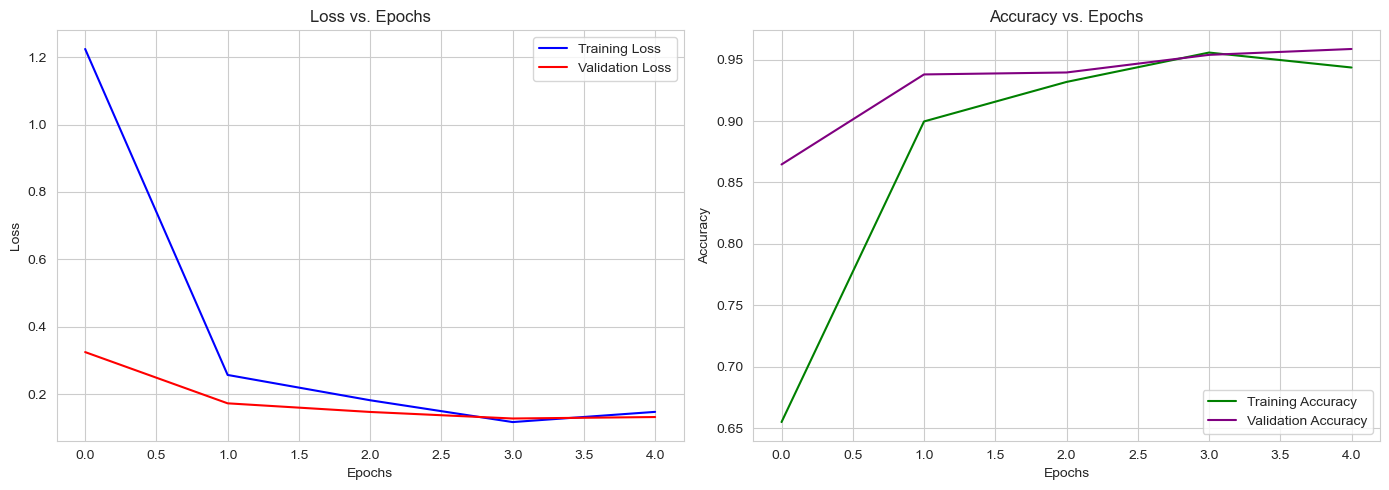

In [24]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()

plt.tight_layout()

### Loading best model weights

In [19]:
loaded_best_model = tf.keras.models.clone_model(model)
loaded_best_model.load_weights(check_log_dir)

loaded_best_model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"])

In [20]:
loaded_best_model.evaluate(test_data)

20/20 [==============================] - 12s 43ms/step - loss: 0.4621 - accuracy: 0.8478


[0.4620932936668396, 0.8477563858032227]

In [21]:
loaded_best_model.evaluate(val_data)

20/20 [==============================] - 8s 40ms/step - loss: 0.1273 - accuracy: 0.9538


[0.12727594375610352, 0.9538216590881348]

As we can see, the model achieves 95% accuracy on both the train and validation data. However, the accuracy drops significantly on the test data. There could be differences in the distribution or characteristics of the test set compared to the validation sets, which can affect the model's performance. Different train/validation splits result in roughly the same performance.

### Saving model

In [22]:
loaded_best_model.save("model.h5")